## Стратегии распределения ресурсных блоков в централизованной сети со случайным графиком

Цель работы:

Получение навыков моделирования стандартных сценариев работы телекоммуникационных систем с топологией типа «звезда». Изучение свойств алгоритмов планирования ресурсов нисходящего кадра в подобных системах. Изучение стратегий распределения ресурсных блоков в централизованной сети со случайным трафиком

Параметры по варианту: <br>
* Модель распределения: **Окумура-Хата, small city**
* $R$, км: **1**
* $P_{TX}$, Вт: **10**
* $f_0$, МГц: **900**
* $k_n$: **2**
* $N_{RB}$: **25**

Используемые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Основная теория


Из сети на БС поступают пакеты для передачи АБ. Объем каждого пакета равен $V_п = 1 \ кбайт$.

Каждому АБ внутри БС выделяется буфер. Задача БС - доставить пакеты каждому АБ, при этом буфер не должен переполняться </br>

Для этого время передачи разделено на равные интервалы - **слоты**, длительность которого равна $\tau_{RB} = 0.5 \ мс$.

Количество пакетов $P_i[k]$, поступивших в слоте $k$ для $i$-ого АБ: $ P_i[k] \sim Poison(\lambda)$.

Данные, поступившие на БС в слоте $k$, будут переданы АБ в слоте $k+1$.

Принято выделять 2 канала связи:
1. DownLink (DL, от БС к АБ)
2. UpLink (UL, от АБ к БС) </br>
![image.png](DL.png)

В данном случае полоса пропускания $\triangle f$ делится на равные интервалы $\triangle f_{RB} = 180 \ кГц$, образуя *ячейку* - **ресурсный блок**

Таким образом: столбцы - **слоты**, строки - **ресурные блоки**. При этом каждая ячейка таблицы имеет следующие размеры:
* $\triangle f_{RB} = 180 \ кГц$ (по высоте);
* $\tau_{RB} = 0.5 \ мс$ (по ширине).

Число внутри ячейки - номер пользователя, которому отдан ресурсный блок. Количество ресурсных блоков $N_{RB}$ определяет количество строк в матрице.

Объем данных, который **может** быть передан $i$-ому абоненту в $j$-ом ресурсном блоке $k$-ого слота: 
$$V_{i, j}[k] = C_{i, j}[k] \cdot \tau_{RB}$$ 
где $\tau_{RB} = 0.5 \ мс$.

### Размещение N абонентов в радиусе R

Формулы для равномерного размещения абонентов в круге радиуса R. Используем полярные координаты:
$$ R = \sqrt{uniform(0, R^2, N)} $$
$$ angle = uniform(0, 2*\pi, N) $$

In [2]:
# Функция размещения абонентов внутри окружности с радиусом R
def create_abons(N, R, circle: bool = False):
    # Лямбда-функция создания расстояния от АБ до БС (по прямой)
    create_distance = lambda N: np.sqrt(np.random.uniform(0, R**2, N))
    distance = create_distance(N)
    if circle:
        create_angle = lambda N: np.random.uniform(0, 2 * np.pi, N)
        angle = create_angle(N)
        theta = np.linspace(0, 2 * np.pi, 100)
        # Для абонентов
        x, y = distance * np.cos(angle), distance * np.sin(angle)

        # Для окружности
        x_r, y_r = R * np.cos(theta), R * np.sin(theta)
        return x, y, x_r, y_r
    return distance

Для перехода к евклидовым координатам используем следующие преобразования:
$$ x = r * cos(angle) $$
$$ y = r * sin(angle) $$

Запустим данную функцию и визуализируем полученные результаты на графике:

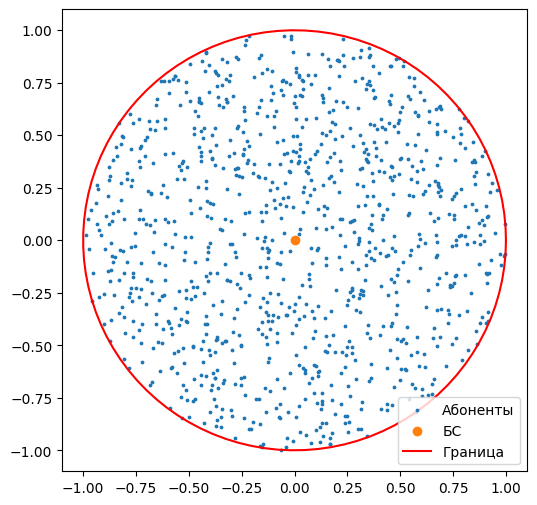

In [31]:
x, y, x_r, y_r = create_abons(1024, 1, True)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label="Абоненты", s=3)
plt.scatter(0, 0, label="БС")
plt.plot(x_r, y_r, label="Граница", color="r")
plt.legend()
plt.show()

### Генерация возможных скоростей передачи от БС к АБ

Объем данных, который **может** быть передан $i$-ому абоненту в $j$-ом ресурсном блоке $k$-ого слота: 
$$V_{i, j}[k] = C_{i, j}[k] \cdot \tau_{RB}$$ 
где $\tau_{RB} = 0.5 \ мс$.

$C_{i, j}[k]$ - максимальная пропускная способность у $i$-ого АБ в $j$-ом ресурсном блоке $k$-ого слота. Данное значение определяется по формуле: 
$$C_{i, j}[k] = \triangle f \log_2 (1 + SNR_{i, j}[k])$$ 

где $\triangle f = 180 \ кГц$. Из данной формулы необходимо найти $SNR_{i, j}[k]$. Данное значение вычисляется по формуле:
$$ SNR_{i, j}[k] = \frac{P_{i, j}[k]}{P_N} $$

где $$ P_N = \triangle f \cdot T \cdot k \cdot k_N $$ Формула для подсчета величины $P_{i, j}[k]$ выглядит следующим образом:
$$P_{i, j}[k] = \frac{P_{TX}}{L_{i, j}[k]}$$

Во всех вышеприведённых формулах известны следующие значения:
* $\triangle f = 180 \ (кГц)$ - полоса пропускания канала связи БС;
* $T = 300 \ (К)$ - абсолютная температура;
* $k = 1.38 \cdot 10^{-23} \ (Дж/К)$ - постоянная Больцмана;
* $k_n = 2$ - коэффициент теплового шума приёмника;
* $P_{TX} = 10 \ (Вт)$ - мощность излучения БС.

Для созданных расстояний до АБ необходимо найти степень затухания сигнала $L_{i, j}[k]$. Она определяется по формуле:
$$L_{i, j}[k] = L_i + x_{i, j}[k]$$
где $x_{i, j}[k] \sim Normal(\mu = 0, \sigma = 1)$ </br> $L_i$ - среднее затухание в канале от БС до $i$-ого АБ найденное при помощи модели Окамура-Хата. Формула выглядит следующим образом:
$$ 10 \lg L_i = 46.3 + 33.9\cdot\lg f_0 - 13.82\cdot\lg h_{БС} - \alpha(h_{RX}) + [44.9 - 6.55\cdot\lg h_{RX}]\lg d + S $$
В данной формуле изначально даны следующие параметры:
* $f_0 = 900 \ (МГц)$ - Частота сигнала; 
* $S = 0$ - параметр, зависящий от среды распространения сигнала (small city = 0, large city = 3);
* $h_{БС} = 30 \ (м)$ - высота БС;
* $h_{RX} = 2 \ (м)$ - высота точки приёма;


Величина $\alpha(h_{RX})$ высчитывается как:
$$ \alpha(h_{RX}) = (1.1 \cdot \lg f_0 - 0.7)h_{RX} - (1.56 \cdot \lg f_0 - 0.8) $$

In [20]:
def generate_subs(distance, slots_amount, tau):
    # Задаём базовые параметры
    f_0, S = 900, 0
    h_bs, h_rx = 30, 2
    delta_f, T = 180 * 10**3, 300
    k, k_n = 1.38 * 10 ** (-23), 2
    P_tx = 10

    # Подсчитываем величину a(h_rx)
    alpha_h_rx = (1.1 * np.log10(f_0) - 0.7) * h_rx - (1.56 * np.log10(f_0) - 0.8)

    # Потери мощности сигнала (lg(L))
    lg_l = (
        46.3
        + 33.9 * np.log10(f_0)
        - 13.82 * np.log10(h_bs)
        - alpha_h_rx
        + (44.9 - 6.55 * np.log10(h_rx)) * np.log10(distance)
        + S
    ) / 10

    # Потери мощности сигнала (L)
    L = 10 ** (lg_l)

    # Случайное затухание сигнала
    L = L + np.random.normal(loc=0, scale=1, size=len(L))

    # Принятая мощность сигнала (P_rx) (Вт)
    P_rx = P_tx / L

    # Мощность теплового шума (P_n) (Вт)
    P_n = delta_f * T * k * k_n

    # Соотношение сигнал/шум (SNR)
    SNR = P_rx / P_n

    # Максимальная пропускная способность канала (кбит/с)
    C = (delta_f * np.log2(1 + SNR)) / 8192

    # Создаём и заполняем датафрейм
    subs = pd.DataFrame(columns=range(slots_amount))
    for sub_i, C_i in enumerate(C):
        subs.loc[f"sub_{sub_i}"] = C_i * tau
    return subs

In [27]:
N_abons, R = 2, 1
distances = create_abons(N_abons, R)

tau, N_rb = 5 * 10 ** (-4), 1000
subs = generate_subs(distances, N_rb, tau)

subs

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
sub_0,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436,...,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436,0.169436
sub_1,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031,...,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031,0.145031


### Формирование пуассоновской случайной величины

Для каждого абонента необходимо создать величину $ P_i[k] \sim Poison(\lambda)$, означающая количество пакетов объёма 1 кбайт, поступающих в буфер БС для $i$-ого АБ.

In [29]:
def generate_P(lambda_, subs):
    packs = pd.DataFrame(
        columns=subs.columns,
        data=[
            np.random.poisson(lambda_, len(subs.columns))
            for _ in range(len(subs.index))
        ]
    )
    return packs


generate_P(0.5, subs)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,1,2,0,0,0,1,...,0,0,0,0,1,0,2,0,0,1
1,2,1,0,0,0,0,1,0,0,0,...,2,0,0,0,2,1,1,1,0,1


В данном датафрейме:
* Строки - номер абонента
* Столбцы - номер слота
* Ячейка - количество информационных пакетов

### Расчет значений приоритета пользователей

Существует 3 подхода к распределению ресурсов, основанных на алгоритмах, рассмотренных в предыдущей работе. Но перед тем, как начинать рассматривать данные методы, необходимо ввести некоторые определения:
* $\overline{R_i}[k]$ - средняя скорость загрузки данных $i$-ым АБ к $k$-ому слоту;
* $N_{RB}$ - количество ресурсных блоков;
* $r_i[k] = \displaystyle \sum_{j=1}^{N_{RB}} V_{i,j}[k]$ - объем данных переданных $i$-ому абоненту, если все ресурсы уйдут к $i$-ому;
* $p_{i,j}^{A}[k]$ - приоритет $i$-ого абонента на $j$-ый ресурсный блок в $k$-ом слоте

**Equal Blind**

Данный алгоритм приравнивает среднюю скорость загрузки. Приоритет пользователя определяется следующим образом:
$$p_{i,j}^{EB}[k] = \frac{1}{\overline{R_i}[k]}$$

Как и во всех последующих алгоритмах, ресурсный блок отдаётся тому пользователю, у которого наибольший приоритет: $i = \argmax{(p_{i,j}^{EB}[k])}$. Далее следует реализация данного метода в виде функции:

In [30]:
def priority_EB(subs_R_mean):
    # Расчет приоритетов и возвращение максимального
    subs_priority = [1 / R_i if R_i > 0 else 1 for R_i in subs_R_mean]

    # Получаем список отсортированных индексов АБ по приоритету
    subs_priority_ids = np.argsort(subs_priority)

    return subs_priority_ids

**Maximum Throughput**

Алгоритм "отдаёт" ресурсный блок тому пользователю, у которого максимальна пропускная способность канала связи:
$$p_{i,j}^{MT}[k] = C_{i, j}[k] $$

Далее следует реализация данного метода в виде функции:

In [31]:
def priority_MT(subs_chanel_capacity):
    # Получаем список отсортированных индексов АБ по приоритету
    subs_priority_ids = np.argsort(subs_chanel_capacity)

    return subs_priority_ids

**Proportional Fair**

Алгоритм выравнивания ресурсов, отдаваемых пользователям. Приоритет $i$-ого пользователя на ресурсный блок определяется как:
$$ p_{i,j}^{PF}[k] = \frac{C_{i, j}[k]}{\overline{R_i}[k]} $$

Далее следует реализация данного метода в виде функции:

In [ ]:
def priority_PF(subs_chanel_capacity, subs_R_mean):
    # Расчет приоритетов и возвращение максимального
    subs_priority = [C_i / (R_i if R_i > 0 else 1) for C_i, R_i in zip(subs_chanel_capacity, subs_R_mean)]

    # Получаем список отсортированных индексов АБ по приоритету
    subs_priority_ids = np.argsort(subs_priority)

    return subs_priority_ids

### Расчет средней скорости загрузки

В двух из трёх рассмотренных способов используется значение средней скорости загрузки $i$-ым АБ к $k$-ому слоту. Существует 2 основных способа расчета данного значения:

**Первый способ**

Фиксируется интервал времени $y$ на котором рассчитывается средняя скорость. Определяем количество слотов:
$$ y_{слот} = \left \lceil \frac{y}{\tau_{RB}} \right \rceil $$

Средняя скорость, с которой абонент загружал данные может быть рассчитана как:
$$\overline{R_i}[k] = \frac{\displaystyle \sum_{m=k-1-y}^{k-1} \left [\sum_{j=1}^{N_{RB}} V_{i,j}[m] \cdot b_{i,j} [m] \right]}{y \ или \ y_{слот}}$$

В данной формуле сумма $ \displaystyle \sum_{j=1}^{N_{RB}} V_{i,j}[m] \cdot b_{i,j} [m]$ - показывает объем данных, переданный $i$-ому АБ в $k$-ом слоте.

Далее следует реализация данного метода в виде функции:

In [ ]:
def calc_R_mean():
    # Период расчета средней скорости + количество слотов
    y = 1
    y_slot = np.ceil(y/tau)

    